In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [50]:
#Load train and test Datasets from CSV.
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')

### Exploratory data analysis

In [3]:
#Display the first 5 rows to see example observations.
train.head()

,name,sex
0,nilaja,female
1,ezme,female
2,zhenghe,male
3,aleaya,female
4,yangang,male


In [4]:
#Display the dimensions of the dataset
train.shape, test.shape

((100000, 2), (30000, 2))

In [6]:
#summary of train DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
name    100000 non-null object
sex     100000 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
#summary of test DataFrame
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
name    29999 non-null object
sex     30000 non-null object
dtypes: object(2)
memory usage: 468.9+ KB


In [9]:
#Total missing values for each feature
train.isna().sum(axis=0)

name    0
sex     0
dtype: int64

In [10]:
test.isna().sum()

name    1
sex     0
dtype: int64

* There is only one missing name in the test dataset.

In [51]:
#Drop row with missing name value in testset.
test = test.dropna(axis=0).reset_index(drop=True)

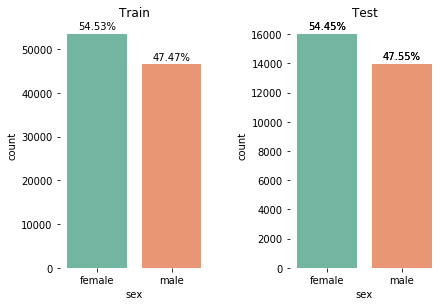

In [12]:
#Class distribution for gender
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(121, frameon=False)
ax2 = fig.add_subplot(122, frameon=False)
plt.tight_layout(w_pad=5)
sns.countplot(x=train.sex, ax=ax1, palette="Set2", order = train.sex.value_counts().index) 
sns.countplot(x=test.sex, ax=ax2, palette="Set2", order = test.sex.value_counts().index)
ax1.title.set_text('Train')
ax2.title.set_text('Test')
for p in ax1.patches:
    total1 = float(len(train))
    height = 1.02*p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total1),
            ha="center");
    for p in ax2.patches:
        total2 = float(len(test))
        height = 1.02*p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2%}'.format(height/total2),
                ha="center");

* We have balanced gender classes in our data set

#### Names length analysis

In [52]:
#split between X and y sets
X_train,y_train = train.name, train.sex
X_test, y_test = test.name, test.sex

In [14]:
#funcion: calculate number of characters
def max_char(X):
    count_char = []
    for i in range(len(X)):
        count = len(X[i])
        count_char.append(count)
    return (count_char)

{'Max': 21, 'Mean': 6}


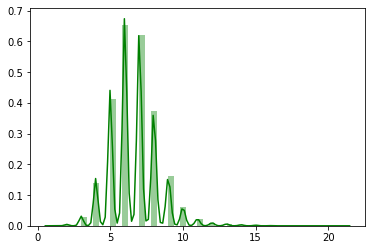

In [15]:
#Train max and mean number of characters
count_char_train = max_char(X_train)
print(({'Max': max(count_char_train), 'Mean': int(np.mean(count_char_train))}))
sns.distplot(count_char_train, color="green");

{'Max': 19, 'Mean': 6}


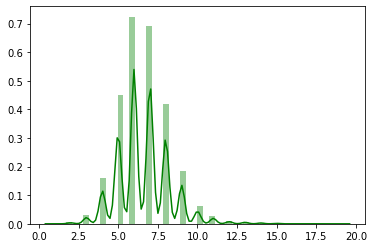

In [16]:
#Train max and mean number of characters
count_char_test = max_char(X_test)
print(({'Max': max(count_char_test), 'Mean': int(np.mean(count_char_test))}))
sns.distplot(count_char_test, color="green");

* The max length for a name in the train and test set is 21 and 19 characters respectively
* Both dataset have a mean length of 6 characters

In [17]:
#let's see the name with 21 characters
for i in range(len(X_train)):
    if len(X_train[i]) == 21:
        print(X_train[i])

konstantinkonstyantyn


In [18]:
#let's see the names with 19 characters
for i in range(len(X_test)):
    if len(X_test[i]) == 19:
        print(X_test[i])

makrissandracamille
venkatasuryaprakash


### Data pre-processing

* First we will transform the names into vectors using integer representing unicode code for each character

In [53]:
def name_to_number(X):
    X_n = []
    for i in range(len(X)):
        name = X[i]
        name  = name.lower()
        numbers = []
        for character in name:
            number = ord(character) - 96
            numbers.append(number)
        X_n.append(numbers)
    return(X_n)

In [54]:
X_train = name_to_number(X_train)
X_test =  name_to_number(X_test)

In [55]:
#Pads sequences to the same length. We'll use a max lenght of 15 characters.
X_train = pad_sequences(X_train, maxlen=15, dtype='int32', padding='post', truncating='post', value=0.0)
X_test = pad_sequences(X_test, maxlen=15, dtype='int32', padding='post', truncating='post', value=0.0) 

In [56]:
#Encode gender with values 0 and 1
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'female': 0, 'male': 1}


In [57]:
#Let's see the dimensions of X and y datasets
X_train.shape, y_train.shape

((100000, 15), (100000,))

### Machine Learning Models

#### LighGBM Classifier

In [73]:
from lightgbm import LGBMClassifier
from sklearn import model_selection
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

* We use Randomized search on hyper parameters:

In [74]:
#Set up Parameter search
param_test ={'num_leaves': sp_randint(10, 500),
             'max_depth' : (10, 50, 100, 500),
             'learning_rate': [0.1, 0.01, 0.001],
             'n_estimators':sp_randint(100, 5000, 10000)}

#Use test subset for early stopping criterion
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'binary_logloss', 
            "eval_set" : [(X_test,y_test)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [75]:
clf = LGBMClassifier(random_state=42, silent=True, metric='binary', n_jobs=-1)

In [76]:
rs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=42,
    verbose=True)

In [77]:
rs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(rs.best_score_, rs.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training until validation scores don't improve for 10 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid_0's binary_logloss: 0.648093	valid_0's binary_logloss: 0.648093
[200]	valid_0's binary_logloss: 0.612573	valid_0's binary_logloss: 0.612573
[300]	valid_0's binary_logloss: 0.582728	valid_0's binary_logloss: 0.582728
[400]	valid_0's binary_logloss: 0.55749	valid_0's binary_logloss: 0.55749
[500]	valid_0's binary_logloss: 0.536177	valid_0's binary_logloss: 0.536177
[600]	valid_0's binary_logloss: 0.517965	valid_0's binary_logloss: 0.517965
[700]	valid_0's binary_logloss: 0.502314	valid_0's binary_logloss: 0.502314
[800]	valid_0's binary_logloss: 0.488713	valid_0's binary_logloss: 0.488713
[900]	valid_0's binary_logloss: 0.47692	valid_0's binary_logloss: 0.47692
[1000]	valid_0's binary_logloss: 0.466586	valid_0's binary_logloss: 0.466586
[1100]	valid_0's binary_logloss: 0.457779	valid_0's binary_logloss: 0.457779
[1200]	valid_0's binary_logloss: 0.450078	valid_0's binary_logloss: 0.450078
[1300]	valid_0's binary_logloss: 0.443158	valid_0's binary_logloss: 0.443158
[1400]	valid

[10800]	valid_0's binary_logloss: 0.318742	valid_0's binary_logloss: 0.318742
[10900]	valid_0's binary_logloss: 0.318504	valid_0's binary_logloss: 0.318504
Did not meet early stopping. Best iteration is:
[10960]	valid_0's binary_logloss: 0.31838	valid_0's binary_logloss: 0.31838
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.647734	valid_0's binary_logloss: 0.647734
[200]	valid_0's binary_logloss: 0.612244	valid_0's binary_logloss: 0.612244
[300]	valid_0's binary_logloss: 0.582488	valid_0's binary_logloss: 0.582488
[400]	valid_0's binary_logloss: 0.557221	valid_0's binary_logloss: 0.557221
[500]	valid_0's binary_logloss: 0.535803	valid_0's binary_logloss: 0.535803
[600]	valid_0's binary_logloss: 0.517625	valid_0's binary_logloss: 0.517625
[700]	valid_0's binary_logloss: 0.502154	valid_0's binary_logloss: 0.502154
[800]	valid_0's binary_logloss: 0.488677	valid_0's binary_logloss: 0.488677
[900]	valid_0's binary_logloss: 0.476951	valid_0's

[10400]	valid_0's binary_logloss: 0.320606	valid_0's binary_logloss: 0.320606
[10500]	valid_0's binary_logloss: 0.320414	valid_0's binary_logloss: 0.320414
[10600]	valid_0's binary_logloss: 0.320219	valid_0's binary_logloss: 0.320219
[10700]	valid_0's binary_logloss: 0.320019	valid_0's binary_logloss: 0.320019
[10800]	valid_0's binary_logloss: 0.319812	valid_0's binary_logloss: 0.319812
[10900]	valid_0's binary_logloss: 0.319607	valid_0's binary_logloss: 0.319607
Did not meet early stopping. Best iteration is:
[10960]	valid_0's binary_logloss: 0.319494	valid_0's binary_logloss: 0.319494
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.647871	valid_0's binary_logloss: 0.647871
[200]	valid_0's binary_logloss: 0.612443	valid_0's binary_logloss: 0.612443
[300]	valid_0's binary_logloss: 0.582715	valid_0's binary_logloss: 0.582715
[400]	valid_0's binary_logloss: 0.557508	valid_0's binary_logloss: 0.557508
[500]	valid_0's binary_logloss: 0.53652	

[10000]	valid_0's binary_logloss: 0.321653	valid_0's binary_logloss: 0.321653
[10100]	valid_0's binary_logloss: 0.321364	valid_0's binary_logloss: 0.321364
[10200]	valid_0's binary_logloss: 0.321116	valid_0's binary_logloss: 0.321116
[10300]	valid_0's binary_logloss: 0.32087	valid_0's binary_logloss: 0.32087
[10400]	valid_0's binary_logloss: 0.320622	valid_0's binary_logloss: 0.320622
[10500]	valid_0's binary_logloss: 0.3204	valid_0's binary_logloss: 0.3204
[10600]	valid_0's binary_logloss: 0.320155	valid_0's binary_logloss: 0.320155
[10700]	valid_0's binary_logloss: 0.319909	valid_0's binary_logloss: 0.319909
[10800]	valid_0's binary_logloss: 0.319637	valid_0's binary_logloss: 0.319637
[10900]	valid_0's binary_logloss: 0.319372	valid_0's binary_logloss: 0.319372
Did not meet early stopping. Best iteration is:
[10960]	valid_0's binary_logloss: 0.319204	valid_0's binary_logloss: 0.319204
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.6600

[9600]	valid_0's binary_logloss: 0.403132	valid_0's binary_logloss: 0.403132
[9700]	valid_0's binary_logloss: 0.40278	valid_0's binary_logloss: 0.40278
[9800]	valid_0's binary_logloss: 0.402431	valid_0's binary_logloss: 0.402431
[9900]	valid_0's binary_logloss: 0.402095	valid_0's binary_logloss: 0.402095
[10000]	valid_0's binary_logloss: 0.401767	valid_0's binary_logloss: 0.401767
[10100]	valid_0's binary_logloss: 0.40142	valid_0's binary_logloss: 0.40142
[10200]	valid_0's binary_logloss: 0.401087	valid_0's binary_logloss: 0.401087
[10300]	valid_0's binary_logloss: 0.400695	valid_0's binary_logloss: 0.400695
[10400]	valid_0's binary_logloss: 0.40032	valid_0's binary_logloss: 0.40032
[10500]	valid_0's binary_logloss: 0.399918	valid_0's binary_logloss: 0.399918
[10600]	valid_0's binary_logloss: 0.399532	valid_0's binary_logloss: 0.399532
[10700]	valid_0's binary_logloss: 0.399157	valid_0's binary_logloss: 0.399157
[10800]	valid_0's binary_logloss: 0.3988	valid_0's binary_logloss: 0.3988


[6200]	valid_0's binary_logloss: 0.42204	valid_0's binary_logloss: 0.42204
[6300]	valid_0's binary_logloss: 0.421288	valid_0's binary_logloss: 0.421288
[6400]	valid_0's binary_logloss: 0.420586	valid_0's binary_logloss: 0.420586
[6500]	valid_0's binary_logloss: 0.419906	valid_0's binary_logloss: 0.419906
[6600]	valid_0's binary_logloss: 0.419231	valid_0's binary_logloss: 0.419231
[6700]	valid_0's binary_logloss: 0.418544	valid_0's binary_logloss: 0.418544
[6800]	valid_0's binary_logloss: 0.417864	valid_0's binary_logloss: 0.417864
[6900]	valid_0's binary_logloss: 0.417181	valid_0's binary_logloss: 0.417181
[7000]	valid_0's binary_logloss: 0.416534	valid_0's binary_logloss: 0.416534
[7100]	valid_0's binary_logloss: 0.415908	valid_0's binary_logloss: 0.415908
[7200]	valid_0's binary_logloss: 0.415306	valid_0's binary_logloss: 0.415306
[7300]	valid_0's binary_logloss: 0.41471	valid_0's binary_logloss: 0.41471
[7400]	valid_0's binary_logloss: 0.414108	valid_0's binary_logloss: 0.414108
[75

[2900]	valid_0's binary_logloss: 0.468919	valid_0's binary_logloss: 0.468919
[3000]	valid_0's binary_logloss: 0.46681	valid_0's binary_logloss: 0.46681
[3100]	valid_0's binary_logloss: 0.464723	valid_0's binary_logloss: 0.464723
[3200]	valid_0's binary_logloss: 0.462674	valid_0's binary_logloss: 0.462674
[3300]	valid_0's binary_logloss: 0.460668	valid_0's binary_logloss: 0.460668
[3400]	valid_0's binary_logloss: 0.45877	valid_0's binary_logloss: 0.45877
[3500]	valid_0's binary_logloss: 0.456971	valid_0's binary_logloss: 0.456971
[3600]	valid_0's binary_logloss: 0.455206	valid_0's binary_logloss: 0.455206
[3700]	valid_0's binary_logloss: 0.453425	valid_0's binary_logloss: 0.453425
[3800]	valid_0's binary_logloss: 0.451644	valid_0's binary_logloss: 0.451644
[3900]	valid_0's binary_logloss: 0.449908	valid_0's binary_logloss: 0.449908
[4000]	valid_0's binary_logloss: 0.448305	valid_0's binary_logloss: 0.448305
[4100]	valid_0's binary_logloss: 0.446767	valid_0's binary_logloss: 0.446767
[42

[13600]	valid_0's binary_logloss: 0.391082	valid_0's binary_logloss: 0.391082
[13700]	valid_0's binary_logloss: 0.390782	valid_0's binary_logloss: 0.390782
[13800]	valid_0's binary_logloss: 0.390493	valid_0's binary_logloss: 0.390493
Did not meet early stopping. Best iteration is:
[13872]	valid_0's binary_logloss: 0.390299	valid_0's binary_logloss: 0.390299
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.648947	valid_0's binary_logloss: 0.648947
[200]	valid_0's binary_logloss: 0.614117	valid_0's binary_logloss: 0.614117
[300]	valid_0's binary_logloss: 0.584797	valid_0's binary_logloss: 0.584797
[400]	valid_0's binary_logloss: 0.560094	valid_0's binary_logloss: 0.560094
[500]	valid_0's binary_logloss: 0.539533	valid_0's binary_logloss: 0.539533
[600]	valid_0's binary_logloss: 0.521906	valid_0's binary_logloss: 0.521906
[700]	valid_0's binary_logloss: 0.506683	valid_0's binary_logloss: 0.506683
[800]	valid_0's binary_logloss: 0.493482	valid

[10300]	valid_0's binary_logloss: 0.325607	valid_0's binary_logloss: 0.325607
[10400]	valid_0's binary_logloss: 0.325322	valid_0's binary_logloss: 0.325322
[10500]	valid_0's binary_logloss: 0.325023	valid_0's binary_logloss: 0.325023
Did not meet early stopping. Best iteration is:
[10566]	valid_0's binary_logloss: 0.324853	valid_0's binary_logloss: 0.324853
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.648592	valid_0's binary_logloss: 0.648592
[200]	valid_0's binary_logloss: 0.613731	valid_0's binary_logloss: 0.613731
[300]	valid_0's binary_logloss: 0.584492	valid_0's binary_logloss: 0.584492
[400]	valid_0's binary_logloss: 0.559839	valid_0's binary_logloss: 0.559839
[500]	valid_0's binary_logloss: 0.538828	valid_0's binary_logloss: 0.538828
[600]	valid_0's binary_logloss: 0.521258	valid_0's binary_logloss: 0.521258
[700]	valid_0's binary_logloss: 0.506247	valid_0's binary_logloss: 0.506247
[800]	valid_0's binary_logloss: 0.493332	valid

[10300]	valid_0's binary_logloss: 0.326143	valid_0's binary_logloss: 0.326143
[10400]	valid_0's binary_logloss: 0.325832	valid_0's binary_logloss: 0.325832
[10500]	valid_0's binary_logloss: 0.325598	valid_0's binary_logloss: 0.325598
Did not meet early stopping. Best iteration is:
[10566]	valid_0's binary_logloss: 0.325444	valid_0's binary_logloss: 0.325444
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.648777	valid_0's binary_logloss: 0.648777
[200]	valid_0's binary_logloss: 0.614068	valid_0's binary_logloss: 0.614068
[300]	valid_0's binary_logloss: 0.585001	valid_0's binary_logloss: 0.585001
[400]	valid_0's binary_logloss: 0.560486	valid_0's binary_logloss: 0.560486
[500]	valid_0's binary_logloss: 0.540125	valid_0's binary_logloss: 0.540125
[600]	valid_0's binary_logloss: 0.52272	valid_0's binary_logloss: 0.52272
[700]	valid_0's binary_logloss: 0.50785	valid_0's binary_logloss: 0.50785
[800]	valid_0's binary_logloss: 0.494881	valid_0's

[10300]	valid_0's binary_logloss: 0.327021	valid_0's binary_logloss: 0.327021
[10400]	valid_0's binary_logloss: 0.326767	valid_0's binary_logloss: 0.326767
[10500]	valid_0's binary_logloss: 0.326521	valid_0's binary_logloss: 0.326521
Did not meet early stopping. Best iteration is:
[10566]	valid_0's binary_logloss: 0.326333	valid_0's binary_logloss: 0.326333
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.651946	valid_0's binary_logloss: 0.651946
[200]	valid_0's binary_logloss: 0.619741	valid_0's binary_logloss: 0.619741
[300]	valid_0's binary_logloss: 0.593109	valid_0's binary_logloss: 0.593109
[400]	valid_0's binary_logloss: 0.571241	valid_0's binary_logloss: 0.571241
[500]	valid_0's binary_logloss: 0.552645	valid_0's binary_logloss: 0.552645
[600]	valid_0's binary_logloss: 0.536821	valid_0's binary_logloss: 0.536821
[700]	valid_0's binary_logloss: 0.523068	valid_0's binary_logloss: 0.523068
[800]	valid_0's binary_logloss: 0.511029	valid

[10300]	valid_0's binary_logloss: 0.348037	valid_0's binary_logloss: 0.348037
[10400]	valid_0's binary_logloss: 0.347778	valid_0's binary_logloss: 0.347778
[10500]	valid_0's binary_logloss: 0.347495	valid_0's binary_logloss: 0.347495
[10600]	valid_0's binary_logloss: 0.347209	valid_0's binary_logloss: 0.347209
[10700]	valid_0's binary_logloss: 0.346929	valid_0's binary_logloss: 0.346929
[10800]	valid_0's binary_logloss: 0.346676	valid_0's binary_logloss: 0.346676
[10900]	valid_0's binary_logloss: 0.346414	valid_0's binary_logloss: 0.346414
[11000]	valid_0's binary_logloss: 0.346135	valid_0's binary_logloss: 0.346135
[11100]	valid_0's binary_logloss: 0.345854	valid_0's binary_logloss: 0.345854
[11200]	valid_0's binary_logloss: 0.345601	valid_0's binary_logloss: 0.345601
[11300]	valid_0's binary_logloss: 0.345345	valid_0's binary_logloss: 0.345345
[11400]	valid_0's binary_logloss: 0.345069	valid_0's binary_logloss: 0.345069
[11500]	valid_0's binary_logloss: 0.344789	valid_0's binary_logl

[7200]	valid_0's binary_logloss: 0.361333	valid_0's binary_logloss: 0.361333
[7300]	valid_0's binary_logloss: 0.360795	valid_0's binary_logloss: 0.360795
[7400]	valid_0's binary_logloss: 0.360263	valid_0's binary_logloss: 0.360263
[7500]	valid_0's binary_logloss: 0.359725	valid_0's binary_logloss: 0.359725
[7600]	valid_0's binary_logloss: 0.359226	valid_0's binary_logloss: 0.359226
[7700]	valid_0's binary_logloss: 0.358732	valid_0's binary_logloss: 0.358732
[7800]	valid_0's binary_logloss: 0.358264	valid_0's binary_logloss: 0.358264
[7900]	valid_0's binary_logloss: 0.357788	valid_0's binary_logloss: 0.357788
[8000]	valid_0's binary_logloss: 0.357309	valid_0's binary_logloss: 0.357309
[8100]	valid_0's binary_logloss: 0.356855	valid_0's binary_logloss: 0.356855
[8200]	valid_0's binary_logloss: 0.356434	valid_0's binary_logloss: 0.356434
[8300]	valid_0's binary_logloss: 0.356046	valid_0's binary_logloss: 0.356046
[8400]	valid_0's binary_logloss: 0.355658	valid_0's binary_logloss: 0.355658

[4100]	valid_0's binary_logloss: 0.39105	valid_0's binary_logloss: 0.39105
[4200]	valid_0's binary_logloss: 0.389543	valid_0's binary_logloss: 0.389543
[4300]	valid_0's binary_logloss: 0.388096	valid_0's binary_logloss: 0.388096
[4400]	valid_0's binary_logloss: 0.386689	valid_0's binary_logloss: 0.386689
[4500]	valid_0's binary_logloss: 0.385318	valid_0's binary_logloss: 0.385318
[4600]	valid_0's binary_logloss: 0.383997	valid_0's binary_logloss: 0.383997
[4700]	valid_0's binary_logloss: 0.382746	valid_0's binary_logloss: 0.382746
[4800]	valid_0's binary_logloss: 0.381562	valid_0's binary_logloss: 0.381562
[4900]	valid_0's binary_logloss: 0.380495	valid_0's binary_logloss: 0.380495
[5000]	valid_0's binary_logloss: 0.379418	valid_0's binary_logloss: 0.379418
[5100]	valid_0's binary_logloss: 0.378395	valid_0's binary_logloss: 0.378395
[5200]	valid_0's binary_logloss: 0.377297	valid_0's binary_logloss: 0.377297
[5300]	valid_0's binary_logloss: 0.376244	valid_0's binary_logloss: 0.376244
[

[1000]	valid_0's binary_logloss: 0.461728	valid_0's binary_logloss: 0.461728
[1100]	valid_0's binary_logloss: 0.45246	valid_0's binary_logloss: 0.45246
[1200]	valid_0's binary_logloss: 0.444592	valid_0's binary_logloss: 0.444592
[1300]	valid_0's binary_logloss: 0.437585	valid_0's binary_logloss: 0.437585
[1400]	valid_0's binary_logloss: 0.431173	valid_0's binary_logloss: 0.431173
[1500]	valid_0's binary_logloss: 0.425304	valid_0's binary_logloss: 0.425304
[1600]	valid_0's binary_logloss: 0.41994	valid_0's binary_logloss: 0.41994
[1700]	valid_0's binary_logloss: 0.414894	valid_0's binary_logloss: 0.414894
[1800]	valid_0's binary_logloss: 0.410068	valid_0's binary_logloss: 0.410068
[1900]	valid_0's binary_logloss: 0.40565	valid_0's binary_logloss: 0.40565
[2000]	valid_0's binary_logloss: 0.401656	valid_0's binary_logloss: 0.401656
[2100]	valid_0's binary_logloss: 0.397801	valid_0's binary_logloss: 0.397801
[2200]	valid_0's binary_logloss: 0.394264	valid_0's binary_logloss: 0.394264
[2300

[700]	valid_0's binary_logloss: 0.498044	valid_0's binary_logloss: 0.498044
[800]	valid_0's binary_logloss: 0.484216	valid_0's binary_logloss: 0.484216
[900]	valid_0's binary_logloss: 0.472208	valid_0's binary_logloss: 0.472208
[1000]	valid_0's binary_logloss: 0.461704	valid_0's binary_logloss: 0.461704
[1100]	valid_0's binary_logloss: 0.452393	valid_0's binary_logloss: 0.452393
[1200]	valid_0's binary_logloss: 0.444438	valid_0's binary_logloss: 0.444438
[1300]	valid_0's binary_logloss: 0.437592	valid_0's binary_logloss: 0.437592
[1400]	valid_0's binary_logloss: 0.4314	valid_0's binary_logloss: 0.4314
[1500]	valid_0's binary_logloss: 0.425897	valid_0's binary_logloss: 0.425897
[1600]	valid_0's binary_logloss: 0.420427	valid_0's binary_logloss: 0.420427
[1700]	valid_0's binary_logloss: 0.415422	valid_0's binary_logloss: 0.415422
[1800]	valid_0's binary_logloss: 0.410784	valid_0's binary_logloss: 0.410784
[1900]	valid_0's binary_logloss: 0.406368	valid_0's binary_logloss: 0.406368
[2000]

[400]	valid_0's binary_logloss: 0.554799	valid_0's binary_logloss: 0.554799
[500]	valid_0's binary_logloss: 0.533211	valid_0's binary_logloss: 0.533211
[600]	valid_0's binary_logloss: 0.514831	valid_0's binary_logloss: 0.514831
[700]	valid_0's binary_logloss: 0.499054	valid_0's binary_logloss: 0.499054
[800]	valid_0's binary_logloss: 0.485416	valid_0's binary_logloss: 0.485416
[900]	valid_0's binary_logloss: 0.47352	valid_0's binary_logloss: 0.47352
[1000]	valid_0's binary_logloss: 0.463092	valid_0's binary_logloss: 0.463092
[1100]	valid_0's binary_logloss: 0.453908	valid_0's binary_logloss: 0.453908
[1200]	valid_0's binary_logloss: 0.446005	valid_0's binary_logloss: 0.446005
[1300]	valid_0's binary_logloss: 0.438673	valid_0's binary_logloss: 0.438673
[1400]	valid_0's binary_logloss: 0.432103	valid_0's binary_logloss: 0.432103
[1500]	valid_0's binary_logloss: 0.426104	valid_0's binary_logloss: 0.426104
[1600]	valid_0's binary_logloss: 0.420381	valid_0's binary_logloss: 0.420381
[1700]	

[100]	valid_0's binary_logloss: 0.474691	valid_0's binary_logloss: 0.474691
[200]	valid_0's binary_logloss: 0.417781	valid_0's binary_logloss: 0.417781
[300]	valid_0's binary_logloss: 0.387691	valid_0's binary_logloss: 0.387691
[400]	valid_0's binary_logloss: 0.368549	valid_0's binary_logloss: 0.368549
[500]	valid_0's binary_logloss: 0.35547	valid_0's binary_logloss: 0.35547
[600]	valid_0's binary_logloss: 0.346606	valid_0's binary_logloss: 0.346606
[700]	valid_0's binary_logloss: 0.340184	valid_0's binary_logloss: 0.340184
[800]	valid_0's binary_logloss: 0.335521	valid_0's binary_logloss: 0.335521
[900]	valid_0's binary_logloss: 0.332107	valid_0's binary_logloss: 0.332107
[1000]	valid_0's binary_logloss: 0.329075	valid_0's binary_logloss: 0.329075
[1100]	valid_0's binary_logloss: 0.3266	valid_0's binary_logloss: 0.3266
[1200]	valid_0's binary_logloss: 0.32448	valid_0's binary_logloss: 0.32448
[1300]	valid_0's binary_logloss: 0.322435	valid_0's binary_logloss: 0.322435
[1400]	valid_0's

[300]	valid_0's binary_logloss: 0.396202	valid_0's binary_logloss: 0.396202
[400]	valid_0's binary_logloss: 0.376151	valid_0's binary_logloss: 0.376151
[500]	valid_0's binary_logloss: 0.364288	valid_0's binary_logloss: 0.364288
[600]	valid_0's binary_logloss: 0.355106	valid_0's binary_logloss: 0.355106
[700]	valid_0's binary_logloss: 0.347875	valid_0's binary_logloss: 0.347875
[800]	valid_0's binary_logloss: 0.342599	valid_0's binary_logloss: 0.342599
[900]	valid_0's binary_logloss: 0.338117	valid_0's binary_logloss: 0.338117
[1000]	valid_0's binary_logloss: 0.33465	valid_0's binary_logloss: 0.33465
[1100]	valid_0's binary_logloss: 0.331354	valid_0's binary_logloss: 0.331354
[1200]	valid_0's binary_logloss: 0.328667	valid_0's binary_logloss: 0.328667
[1300]	valid_0's binary_logloss: 0.325949	valid_0's binary_logloss: 0.325949
[1400]	valid_0's binary_logloss: 0.323399	valid_0's binary_logloss: 0.323399
[1500]	valid_0's binary_logloss: 0.321109	valid_0's binary_logloss: 0.321109
[1600]	v

[1000]	valid_0's binary_logloss: 0.456702	valid_0's binary_logloss: 0.456702
[1100]	valid_0's binary_logloss: 0.447112	valid_0's binary_logloss: 0.447112
[1200]	valid_0's binary_logloss: 0.438856	valid_0's binary_logloss: 0.438856
[1300]	valid_0's binary_logloss: 0.431651	valid_0's binary_logloss: 0.431651
[1400]	valid_0's binary_logloss: 0.425143	valid_0's binary_logloss: 0.425143
[1500]	valid_0's binary_logloss: 0.419075	valid_0's binary_logloss: 0.419075
[1600]	valid_0's binary_logloss: 0.413397	valid_0's binary_logloss: 0.413397
[1700]	valid_0's binary_logloss: 0.408233	valid_0's binary_logloss: 0.408233
[1800]	valid_0's binary_logloss: 0.403505	valid_0's binary_logloss: 0.403505
[1900]	valid_0's binary_logloss: 0.399132	valid_0's binary_logloss: 0.399132
[2000]	valid_0's binary_logloss: 0.395012	valid_0's binary_logloss: 0.395012
[2100]	valid_0's binary_logloss: 0.391099	valid_0's binary_logloss: 0.391099
[2200]	valid_0's binary_logloss: 0.387539	valid_0's binary_logloss: 0.387539

[11700]	valid_0's binary_logloss: 0.308344	valid_0's binary_logloss: 0.308344
[11800]	valid_0's binary_logloss: 0.308227	valid_0's binary_logloss: 0.308227
[11900]	valid_0's binary_logloss: 0.308095	valid_0's binary_logloss: 0.308095
[12000]	valid_0's binary_logloss: 0.307969	valid_0's binary_logloss: 0.307969
[12100]	valid_0's binary_logloss: 0.307838	valid_0's binary_logloss: 0.307838
[12200]	valid_0's binary_logloss: 0.307736	valid_0's binary_logloss: 0.307736
[12300]	valid_0's binary_logloss: 0.307619	valid_0's binary_logloss: 0.307619
[12400]	valid_0's binary_logloss: 0.307519	valid_0's binary_logloss: 0.307519
[12500]	valid_0's binary_logloss: 0.30744	valid_0's binary_logloss: 0.30744
[12600]	valid_0's binary_logloss: 0.307348	valid_0's binary_logloss: 0.307348
[12700]	valid_0's binary_logloss: 0.307291	valid_0's binary_logloss: 0.307291
[12800]	valid_0's binary_logloss: 0.307223	valid_0's binary_logloss: 0.307223
Did not meet early stopping. Best iteration is:
[12834]	valid_0's 

[9400]	valid_0's binary_logloss: 0.312596	valid_0's binary_logloss: 0.312596
[9500]	valid_0's binary_logloss: 0.312355	valid_0's binary_logloss: 0.312355
[9600]	valid_0's binary_logloss: 0.31212	valid_0's binary_logloss: 0.31212
[9700]	valid_0's binary_logloss: 0.311893	valid_0's binary_logloss: 0.311893
[9800]	valid_0's binary_logloss: 0.311646	valid_0's binary_logloss: 0.311646
[9900]	valid_0's binary_logloss: 0.31144	valid_0's binary_logloss: 0.31144
[10000]	valid_0's binary_logloss: 0.311275	valid_0's binary_logloss: 0.311275
[10100]	valid_0's binary_logloss: 0.311121	valid_0's binary_logloss: 0.311121
[10200]	valid_0's binary_logloss: 0.310966	valid_0's binary_logloss: 0.310966
[10300]	valid_0's binary_logloss: 0.3108	valid_0's binary_logloss: 0.3108
[10400]	valid_0's binary_logloss: 0.310632	valid_0's binary_logloss: 0.310632
[10500]	valid_0's binary_logloss: 0.310482	valid_0's binary_logloss: 0.310482
[10600]	valid_0's binary_logloss: 0.310342	valid_0's binary_logloss: 0.310342


[9000]	valid_0's binary_logloss: 0.314021	valid_0's binary_logloss: 0.314021
[9100]	valid_0's binary_logloss: 0.313724	valid_0's binary_logloss: 0.313724
[9200]	valid_0's binary_logloss: 0.313438	valid_0's binary_logloss: 0.313438
[9300]	valid_0's binary_logloss: 0.313134	valid_0's binary_logloss: 0.313134
[9400]	valid_0's binary_logloss: 0.312849	valid_0's binary_logloss: 0.312849
[9500]	valid_0's binary_logloss: 0.312597	valid_0's binary_logloss: 0.312597
[9600]	valid_0's binary_logloss: 0.312383	valid_0's binary_logloss: 0.312383
[9700]	valid_0's binary_logloss: 0.312136	valid_0's binary_logloss: 0.312136
[9800]	valid_0's binary_logloss: 0.311897	valid_0's binary_logloss: 0.311897
[9900]	valid_0's binary_logloss: 0.311647	valid_0's binary_logloss: 0.311647
[10000]	valid_0's binary_logloss: 0.311464	valid_0's binary_logloss: 0.311464
[10100]	valid_0's binary_logloss: 0.311317	valid_0's binary_logloss: 0.311317
[10200]	valid_0's binary_logloss: 0.311131	valid_0's binary_logloss: 0.311

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 79.6min finished


Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.32373	valid_0's binary_logloss: 0.32373
[200]	valid_0's binary_logloss: 0.300659	valid_0's binary_logloss: 0.300659
[300]	valid_0's binary_logloss: 0.291635	valid_0's binary_logloss: 0.291635
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.289222	valid_0's binary_logloss: 0.289222
Best score reached: 0.8719 with params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 14655, 'num_leaves': 323} 


In [88]:
lgbm_clf = LGBMClassifier(**clf.get_params())
#set optimal parameters
lgbm_clf.set_params(**rs.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               metric='binary', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=14655, n_jobs=-1,
               num_leaves=323, objective=None, random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [97]:
#Train the final model

lgbm_clf.fit(X_train, y_train, **fit_params)

y_pred_train = lgbm_clf.predict(X_train)
y_pred_test = lgbm_clf.predict(X_test)

acc_train= accuracy_score(y_train, y_pred_train)
acc_test= accuracy_score(y_test, y_pred_test)

print('Lightgbm accuracy train:', acc_train) 
print('Lightgbm accuracy test:', acc_test)

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.32373	valid_0's binary_logloss: 0.32373
[200]	valid_0's binary_logloss: 0.300659	valid_0's binary_logloss: 0.300659
[300]	valid_0's binary_logloss: 0.291635	valid_0's binary_logloss: 0.291635
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.289222	valid_0's binary_logloss: 0.289222
Lightgbm accuracy train: 0.94643
Lightgbm accuracy test: 0.8811293709790327


In [100]:
# Function to predict gender from name:
def predict_gender(name):
    name  = name.lower()
    l = 15 - len(name)
    numbers = []
    for character in name:
        number = ord(character) - 96
        numbers.append(number)
    numbers = np.pad(np.array(numbers), (0, l), 'constant').reshape(1, 15)
    pred = lgbm_clf.predict(numbers)
    if pred == 0:
        print('Female')
    else:
        print('Male')

In [105]:
predict_gender('Oscar')

Male


### Recurrent Neural Network

In [107]:
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Lambda, SimpleRNN, BatchNormalization,Dropout, Activation
from keras.models import Sequential

In [108]:
# Firs convert names vectors to binary class matrices
X_train = to_categorical(X_train)
X_test = to_categorical(X_test)

In [142]:
# Define the model
model = Sequential()
model.temp = 1
model.add(SimpleRNN(100, input_shape = (15, 27), kernel_regularizer = 'l2'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', metrics = ['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs = 100, batch_size= 100, 
          validation_data=(X_test, y_test), verbose = 1)

# compute test accuracy
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_train = accuracy_score(y_pred_train>0.5, y_train>0.5)
acc_test = accuracy_score(y_pred_test>0.5, y_test>0.5)
print('RNN accuracy train:', acc_train) 
print('RNN accuracy test:', acc_test)

Train on 100000 samples, validate on 29999 samples
Epoch 1/100
100000/100000 [==============================] - 15s 149us/step - loss: 0.5682 - acc: 0.7645 - val_loss: 0.4430 - val_acc: 0.8205
Epoch 2/100
100000/100000 [==============================] - 13s 129us/step - loss: 0.4418 - acc: 0.8164 - val_loss: 0.4489 - val_acc: 0.8101
Epoch 3/100
100000/100000 [==============================] - 13s 134us/step - loss: 0.4291 - acc: 0.8216 - val_loss: 0.4313 - val_acc: 0.8217
Epoch 4/100
100000/100000 [==============================] - 13s 132us/step - loss: 0.4216 - acc: 0.8253 - val_loss: 0.4121 - val_acc: 0.8313
Epoch 5/100
100000/100000 [==============================] - 13s 128us/step - loss: 0.4167 - acc: 0.8267 - val_loss: 0.4189 - val_acc: 0.8264
Epoch 6/100
100000/100000 [==============================] - 13s 131us/step - loss: 0.4163 - acc: 0.8260 - val_loss: 0.4127 - val_acc: 0.8319
Epoch 7/100
100000/100000 [==============================] - 13s 128us/step - loss: 0.4137 - acc:

In [224]:
# Function to predict gender from name for RNN:

def predict_gender(name):
    
    name  = name.lower()
    l = 15 - len(name)
    numbers = []
    for character in name:
        number = ord(character) - 96
        numbers.append(number)
    numbers = np.pad(np.array(numbers), (0, l), 'constant').reshape(1, 15)
    numbers = to_categorical(numbers, num_classes=27)
    pred = model.predict(numbers)
    if pred <= 0.5:
        print('Female')
    else:
        print('Male')

In [233]:
predict_gender('Oscar')

Male
